Running analysis on GPU 1 with 2000 points in 20000 dimensions
Using device: cuda:1
Generated points in 3.70 seconds
Processing x1 = 0.0
Processing x1 = 0.2
Processing x1 = 0.4
Processing x1 = 0.6
Processing x1 = 0.8
Processing x1 = 1.0
Processing x1 = 1.2
Processing x1 = 1.4
Processing x1 = 1.6
Processing x1 = 1.8
Processing x1 = 2.0
Processing x1 = 2.2
Processing x1 = 2.4
Processing x1 = 2.6
Processing x1 = 2.8
Processing x1 = 3.0
Processing x1 = 3.2
Processing x1 = 3.4
Processing x1 = 3.6
Processing x1 = 3.8
Processing x1 = 4.0
Processing x1 = 4.2
Processing x1 = 4.4
Processing x1 = 4.6
Processing x1 = 4.8
Processing x1 = 5.0
Processing x1 = 5.2
Processing x1 = 5.4
Processing x1 = 5.6
Processing x1 = 5.8
Processing x1 = 6.0
Processing x1 = 6.2
Processing x1 = 6.4
Processing x1 = 6.6
Processing x1 = 6.8
Processing x1 = 7.0
Processing x1 = 7.2
Processing x1 = 7.4
Processing x1 = 7.6
Processing x1 = 7.8
Processing x1 = 8.0
Processing x1 = 8.2
Processing x1 = 8.4
Processing x1 = 8.6
Pro

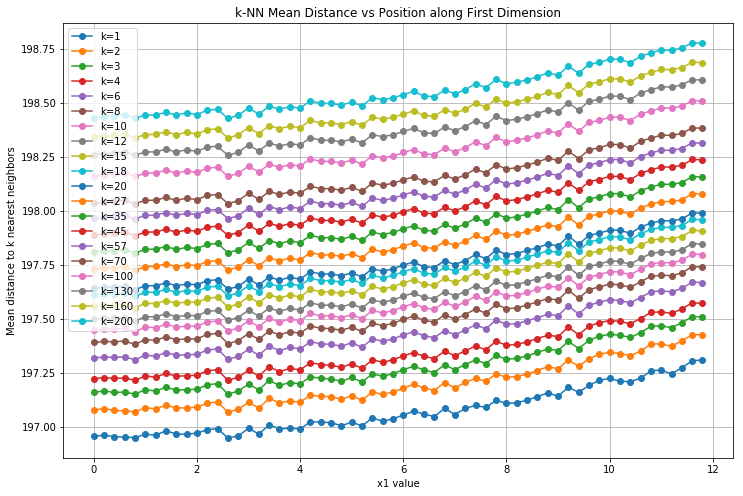

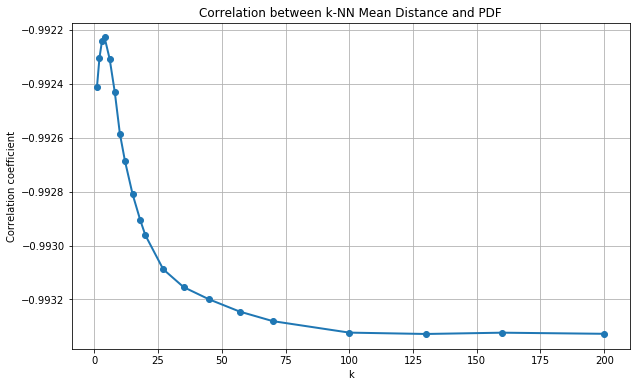

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.stats import pearsonr
import time

def knn_analysis(n_points=2000, n_dim=20000, gpu_id=0, seed=42):
    """
    Analyze k-NN behavior in high dimensions and correlate with PDF.
    
    Args:
        n_points: Number of points to sample
        n_dim: Dimensionality of the space
        gpu_id: GPU to use (0-3)
        seed: Random seed for reproducibility
    """
    print(f"Running analysis on GPU {gpu_id} with {n_points} points in {n_dim} dimensions")
    
    # Set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Set the device
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    if not torch.cuda.is_available():
        print("Warning: CUDA not available, falling back to CPU")
    else:
        print(f"Using device: {device}")
    
    # Generate random points - N(0,I)
    start_time = time.time()
    X = torch.randn(n_points, n_dim, device=device)
    print(f"Generated points in {time.time() - start_time:.2f} seconds")
    
    # Values of k to analyze
    k_values = [1, 2, 3, 4, 6, 8, 10, 12, 15, 18, 20, 27, 35, 45, 57, 70, 100, 130, 160, 200]
    
    # Sample points along first dimension for PDF evaluation
    x1_values = np.arange(0, 12, 0.2)
    n_samples = len(x1_values)
    
    # Store results for each k
    correlations = []
    mean_distances = np.zeros((len(k_values), n_samples))
    
    # Compute log PDF values (without the exponential)
    # n*log(8/sqrt(pi)) + sum xi^2
    log_const = n_dim * np.log(8/np.sqrt(np.pi))
    
    # For each point in x1_values, sample points and compute k-NN distances
    for i, x1 in enumerate(x1_values):
        print(f"Processing x1 = {x1:.1f}")
        
        # Create test points with first dimension fixed to x1
        X_test = torch.randn(n_points, n_dim, device=device)
        X_test[:, 0] = x1  # Set first dimension to x1
        
        # Compute squared distances from X_test to X using PyTorch's optimized operations
        # This involves computing ||x-y||^2 = ||x||^2 + ||y||^2 - 2x·y
        # We'll do this batched to avoid memory issues
        batch_size = 100
        all_distances = []
        
        for b in range(0, n_points, batch_size):
            end_idx = min(b + batch_size, n_points)
            batch = X_test[b:end_idx]
            
            # Compute ||x||^2 for the batch
            batch_norm = torch.sum(batch**2, dim=1, keepdim=True)
            
            # Compute ||y||^2 for all points in X
            X_norm = torch.sum(X**2, dim=1, keepdim=True).T
            
            # Compute 2x·y for the batch with all points in X
            dot_product = 2 * torch.mm(batch, X.T)
            
            # Compute squared distances: ||x||^2 + ||y||^2 - 2x·y
            dist_sq = batch_norm + X_norm - dot_product
            
            # Handle numerical errors
            dist_sq = torch.clamp(dist_sq, min=0.0)
            
            # Take square root to get Euclidean distances
            distances = torch.sqrt(dist_sq)
            all_distances.append(distances)
        
        # Concatenate all batches
        distances_matrix = torch.cat(all_distances, dim=0)
        
        # For each k, compute the mean of the k nearest neighbors
        for j, k in enumerate(k_values):
            # Sort distances and get the k nearest neighbors for each point
            k_nearest, _ = torch.topk(distances_matrix, k, dim=1, largest=False)
            
            # Compute mean distance to k nearest neighbors
            mean_dist = torch.mean(k_nearest, dim=1).cpu().numpy()
            mean_distances[j, i] = np.mean(mean_dist)
        
        # Compute log PDF term: sum of squared values
        log_pdf_term = log_const + torch.sum(X_test**2, dim=1).cpu().numpy()
    
    # For each k, compute correlation between mean distance and log PDF
    for j, k in enumerate(k_values):
        # We need to exponentiate log_pdf_term for correlation
        # But to avoid numerical issues, we'll compute correlation with the log values
        # This is valid since correlation is invariant to monotonic transformations
        pdf_values = -0.5 * np.array([log_const + x1**2 for x1 in x1_values])
        corr, p_value = pearsonr(pdf_values, mean_distances[j, :])
        correlations.append((k, corr, p_value))
        print(f"k={k}: correlation={corr:.4f}, p-value={p_value:.4f}")
    
    # Plot results
    plt.figure(figsize=(12, 8))
    
    for j, k in enumerate(k_values):
        plt.plot(x1_values, mean_distances[j, :], marker='o', label=f'k={k}')
    
    plt.xlabel('x1 value')
    plt.ylabel('Mean distance to k nearest neighbors')
    plt.title('k-NN Mean Distance vs Position along First Dimension')
    plt.legend()
    plt.grid(True)
    
    # Additional plots
    plt.figure(figsize=(10, 6))
    k_array = np.array(k_values)
    corr_array = np.array([c[1] for c in correlations])
    
    plt.plot(k_array, corr_array, marker='o', linewidth=2)
    plt.xlabel('k')
    plt.ylabel('Correlation coefficient')
    plt.title('Correlation between k-NN Mean Distance and PDF')
    plt.grid(True)
    
    # Return results
    return {
        'k_values': k_values,
        'correlations': correlations,
        'mean_distances': mean_distances,
        'x1_values': x1_values
    }

# Example usage in a Jupyter notebook:
results = knn_analysis(n_points=2000, n_dim=20000, gpu_id=1)
 
# To run on a different GPU:
# # results = knn_analysis(n_points=2000, n_dim=20000, gpu_id=1)


Running analysis with p-norm = 0.5
Running analysis on GPU 1 with 2000 points in 20000 dimensions
Using L0.5 norm (p=0.5)
Using device: cuda:1
Generated points in 0.02 seconds
Processing x1 = 0.0
Processing x1 = 0.2
Processing x1 = 0.4
Processing x1 = 0.6
Processing x1 = 0.8
Processing x1 = 1.0
Processing x1 = 1.2
Processing x1 = 1.4
Processing x1 = 1.6
Processing x1 = 1.8
Processing x1 = 2.0
Processing x1 = 2.2
Processing x1 = 2.4
Processing x1 = 2.6
Processing x1 = 2.8
Processing x1 = 3.0
Processing x1 = 3.2
Processing x1 = 3.4
Processing x1 = 3.6
Processing x1 = 3.8
Processing x1 = 4.0
Processing x1 = 4.2
Processing x1 = 4.4
Processing x1 = 4.6
Processing x1 = 4.8
Processing x1 = 5.0
Processing x1 = 5.2
Processing x1 = 5.4
Processing x1 = 5.6
Processing x1 = 5.8
k=1: correlation=-0.5872, p-value=0.0006
k=2: correlation=-0.5960, p-value=0.0005
k=3: correlation=-0.6047, p-value=0.0004
k=4: correlation=-0.6096, p-value=0.0003
k=6: correlation=-0.6156, p-value=0.0003
k=8: correlation=-

OutOfMemoryError: CUDA out of memory. Tried to allocate 764.00 MiB (GPU 1; 10.76 GiB total capacity; 9.41 GiB already allocated; 55.38 MiB free; 9.89 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

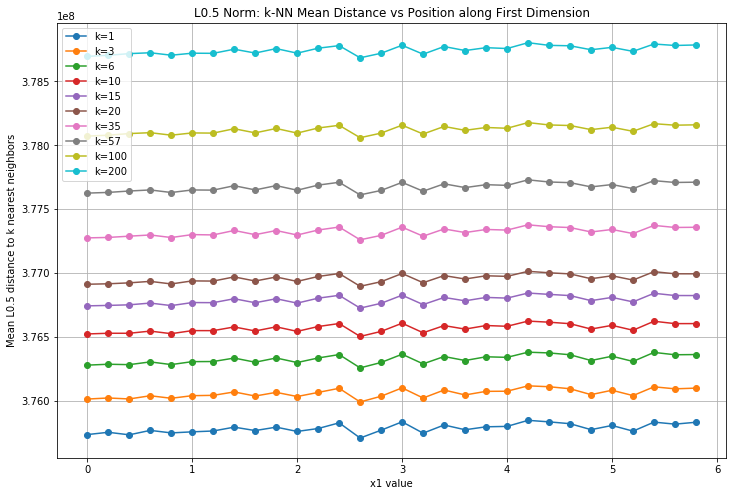

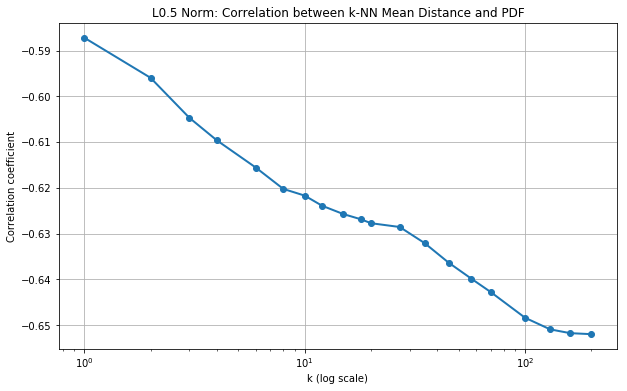

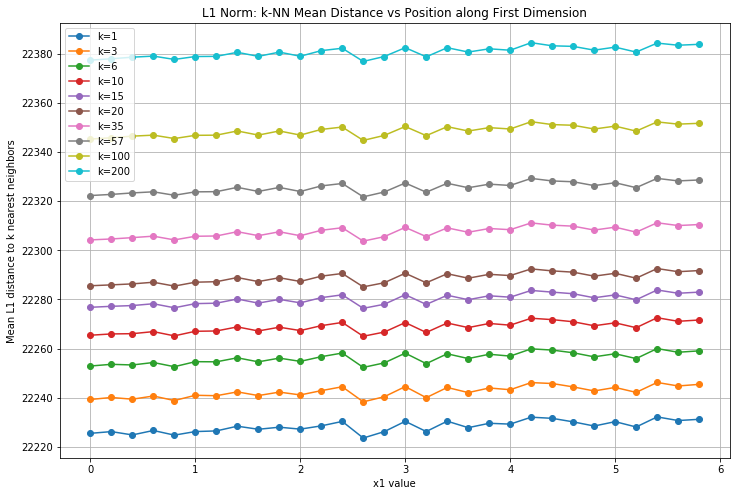

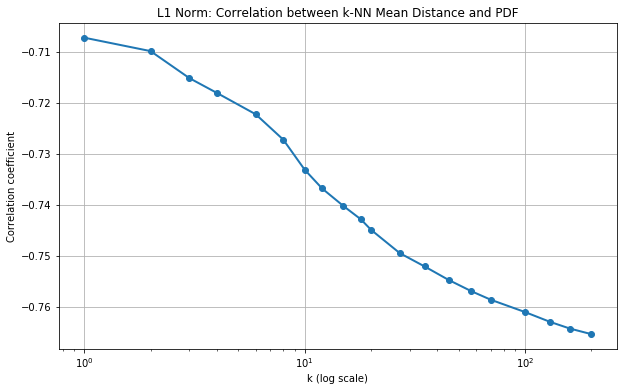

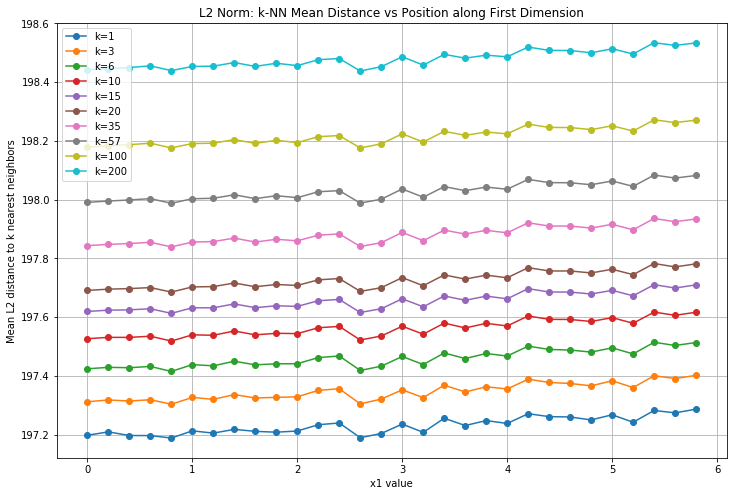

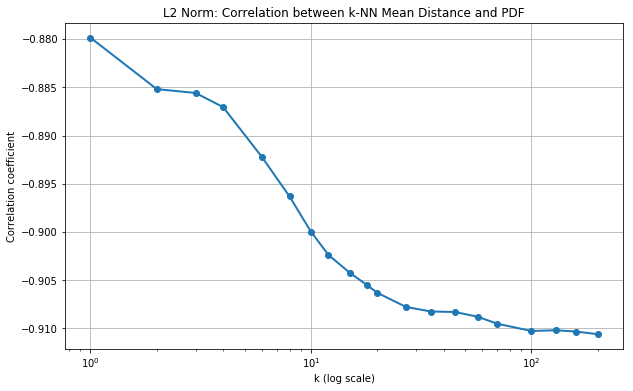

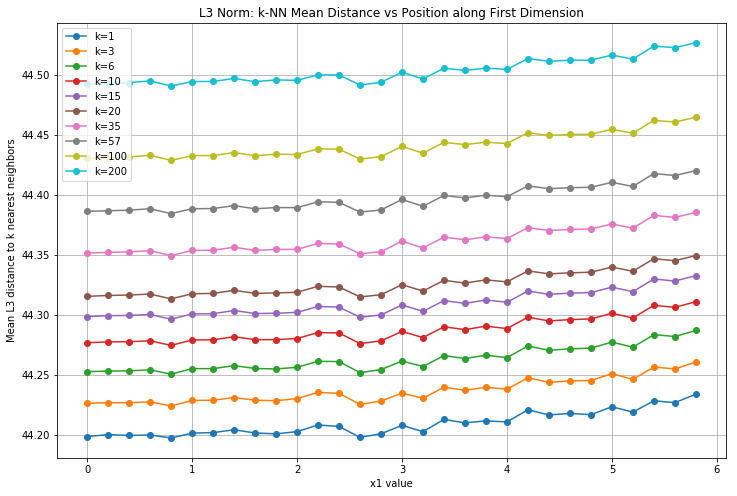

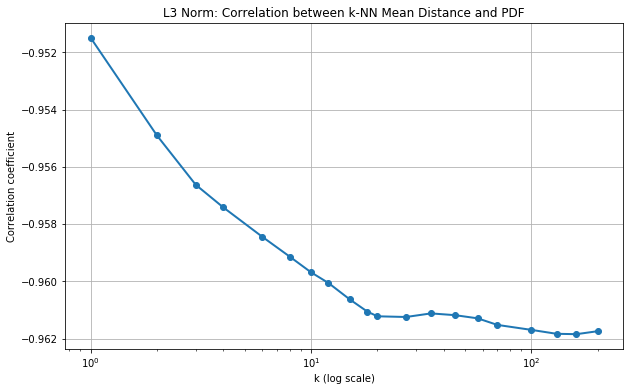

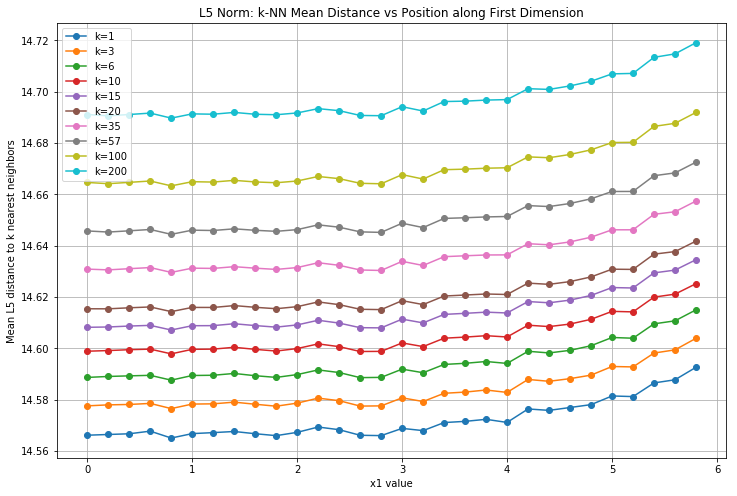

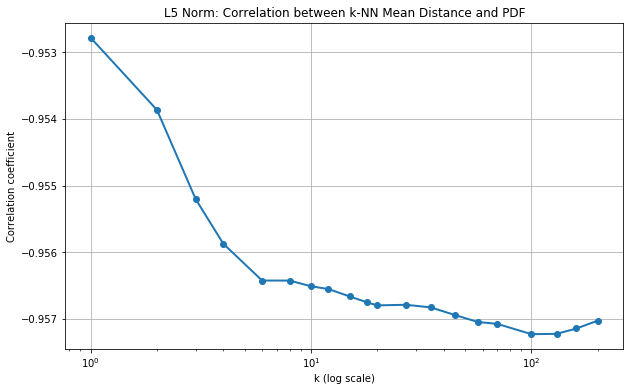

In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import time

def knn_analysis(n_points=2000, n_dim=20000, p_norm='2', gpu_id=0, seed=42):
    """
    Analyze k-NN behavior in high dimensions and correlate with PDF using specified p-norm.
    
    Args:
        n_points: Number of points to sample
        n_dim: Dimensionality of the space
        p_norm: Power of the norm to use (1=Manhattan, 2=Euclidean, 'inf'=Chebyshev)
               Can also be values below 1 like 0.5
        gpu_id: GPU to use (0-3)
        seed: Random seed for reproducibility
    """
    # Convert p_norm to appropriate type
    if p_norm == 'inf':
        p = float('inf')
    else:
        p = float(p_norm)
    
    print(f"Running analysis on GPU {gpu_id} with {n_points} points in {n_dim} dimensions")
    print(f"Using L{p_norm} norm (p={p})")
    
    # Set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Set the device
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    if not torch.cuda.is_available():
        print("Warning: CUDA not available, falling back to CPU")
    else:
        print(f"Using device: {device}")
    
    # Generate random points - N(0,I)
    start_time = time.time()
    X = torch.randn(n_points, n_dim, device=device)
    print(f"Generated points in {time.time() - start_time:.2f} seconds")
    
    # Values of k to analyze
    k_values = [1, 2, 3, 4, 6, 8, 10, 12, 15, 18, 20, 27, 35, 45, 57, 70, 100, 130, 160, 200]
    
    # Sample points along first dimension for PDF evaluation
    x1_values = np.arange(0, 6, 0.2)
    n_samples = len(x1_values)
    
    # Store results for each k
    correlations = []
    mean_distances = np.zeros((len(k_values), n_samples))
    
    # Compute log PDF values (without the exponential)
    # n*log(8/sqrt(pi)) + sum xi^2
    log_const = n_dim * np.log(8/np.sqrt(np.pi))
    
    # For each point in x1_values, sample points and compute k-NN distances
    for i, x1 in enumerate(x1_values):
        print(f"Processing x1 = {x1:.1f}")
        
        # Create test points with first dimension fixed to x1
        X_test = torch.randn(n_points, n_dim, device=device)
        X_test[:, 0] = x1  # Set first dimension to x1
        
        # Compute distances based on the norm type
        batch_size = 100
        all_distances = []
        
        for b in range(0, n_points, batch_size):
            end_idx = min(b + batch_size, n_points)
            batch = X_test[b:end_idx]
            
            if p == 2:
                # Special case for Euclidean distance (L2 norm)
                # Use the efficient method
                batch_norm = torch.sum(batch**2, dim=1, keepdim=True)
                X_norm = torch.sum(X**2, dim=1, keepdim=True).T
                dot_product = 2 * torch.mm(batch, X.T)
                dist_sq = batch_norm + X_norm - dot_product
                dist_sq = torch.clamp(dist_sq, min=0.0)  # Handle numerical errors
                distances = torch.sqrt(dist_sq)
            elif p == float('inf'):
                # Special case for maximum norm (L∞)
                distances = torch.zeros(end_idx - b, n_points, device=device)
                # Process in dimension chunks to save memory
                chunk_size = 1000
                for dim_start in range(0, n_dim, chunk_size):
                    dim_end = min(dim_start + chunk_size, n_dim)
                    # Get current chunk
                    batch_chunk = batch[:, dim_start:dim_end]
                    X_chunk = X[:, dim_start:dim_end]
                    # Compute absolute differences for this chunk
                    diff_chunk = torch.abs(batch_chunk.unsqueeze(1) - X_chunk.unsqueeze(0))
                    # Update max distances
                    chunk_max = torch.max(diff_chunk, dim=2)[0]
                    distances = torch.max(distances, chunk_max)
            else:
                # General case for any Lp norm
                distances = torch.zeros(end_idx - b, n_points, device=device)
                # Process in dimension chunks to save memory
                chunk_size = 1000
                for dim_start in range(0, n_dim, chunk_size):
                    dim_end = min(dim_start + chunk_size, n_dim)
                    # Get current chunk
                    batch_chunk = batch[:, dim_start:dim_end]
                    X_chunk = X[:, dim_start:dim_end]
                    # Compute powered differences for this chunk
                    diff_chunk = torch.abs(batch_chunk.unsqueeze(1) - X_chunk.unsqueeze(0))
                    powered_diff = torch.pow(diff_chunk, p)
                    # Add to accumulated distances
                    distances += torch.sum(powered_diff, dim=2)
                
                # Apply final power
                distances = torch.pow(distances, 1/p)
            
            all_distances.append(distances)
        
        # Concatenate all batches
        distances_matrix = torch.cat(all_distances, dim=0)
        
        # For each k, compute the mean of the k nearest neighbors
        for j, k in enumerate(k_values):
            # Sort distances and get the k nearest neighbors for each point
            k_nearest, _ = torch.topk(distances_matrix, k+1, dim=1, largest=False)
            
            # Remove the first distance (which might be self-distance)
            k_nearest = k_nearest[:, 1:k+1]
            
            # Compute mean distance to k nearest neighbors
            mean_dist = torch.mean(k_nearest, dim=1).cpu().numpy()
            mean_distances[j, i] = np.mean(mean_dist)
    
    # For each k, compute correlation between mean distance and log PDF
    for j, k in enumerate(k_values):
        # We need to exponentiate log_pdf_term for correlation
        # But to avoid numerical issues, we'll compute correlation with the log values
        # This is valid since correlation is invariant to monotonic transformations
        pdf_values = -0.5 * np.array([log_const + x1**2 for x1 in x1_values])
        corr, p_value = pearsonr(pdf_values, mean_distances[j, :])
        correlations.append((k, corr, p_value))
        print(f"k={k}: correlation={corr:.4f}, p-value={p_value:.4f}")
    
    # Plot results
    plt.figure(figsize=(12, 8))
    
    # If there are many k values, only plot some for clarity
    if len(k_values) > 10:
        plot_indices = np.linspace(0, len(k_values)-1, 10, dtype=int)
        plot_k_values = [k_values[i] for i in plot_indices]
    else:
        plot_indices = range(len(k_values))
        plot_k_values = k_values
    
    for idx in plot_indices:
        plt.plot(x1_values, mean_distances[idx, :], marker='o', label=f'k={k_values[idx]}')
    
    plt.xlabel('x1 value')
    plt.ylabel(f'Mean L{p_norm} distance to k nearest neighbors')
    plt.title(f'L{p_norm} Norm: k-NN Mean Distance vs Position along First Dimension')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'knn_distances_p{p_norm}.png')
    
    # Correlation plot
    plt.figure(figsize=(10, 6))
    k_array = np.array(k_values)
    corr_array = np.array([c[1] for c in correlations])
    
    plt.semilogx(k_array, corr_array, marker='o', linewidth=2)
    plt.xlabel('k (log scale)')
    plt.ylabel('Correlation coefficient')
    plt.title(f'L{p_norm} Norm: Correlation between k-NN Mean Distance and PDF')
    plt.grid(True)
    plt.savefig(f'knn_correlation_p{p_norm}.png')
    
    # Return results
    return {
        'p_norm': p_norm,
        'k_values': k_values,
        'correlations': correlations,
        'mean_distances': mean_distances,
        'x1_values': x1_values
    }

# Example usage in a Jupyter notebook:
# For standard Euclidean distance (L2 norm):
# results = knn_analysis(n_points=2000, n_dim=20000, p_norm='2', gpu_id=0)
# 
# # For Manhattan distance (L1 norm):
# # results = knn_analysis(n_points=2000, n_dim=20000, p_norm='1', gpu_id=0)
# 
# # For maximum/Chebyshev distance (L∞ norm):
# # results = knn_analysis(n_points=2000, n_dim=20000, p_norm='inf', gpu_id=0)
# 
# # For L3 norm:
# # results = knn_analysis(n_points=2000, n_dim=20000, p_norm='3', gpu_id=0)
# 
# # For non-standard norms, like L0.5:
# # results = knn_analysis(n_points=2000, n_dim=20000, p_norm='0.5', gpu_id=0)
# 
# # To run multiple norms sequentially for comparison:
# # norms_to_test = ['0.5', '1', '2', '3', '5', 'inf']
# # all_results = {}
# # for norm in norms_to_test:
# #     print(f"\nRunning analysis with p-norm = {norm}")
# #     all_results[norm] = knn_analysis(n_points=2000, n_dim=20000, p_norm=norm, gpu_id=0)
# #
# # # Create a combined correlation plot for all norms
# # plt.figure(figsize=(12, 8))
# # for norm, results in all_results.items():
# #     k_values = results['k_values']
# #     correlations = [c[1] for c in results['correlations']]
# #     plt.semilogx(k_values, correlations, marker='o', linewidth=2, label=f'L{norm}')
# # plt.xlabel('k (log scale)')
# # plt.ylabel('Correlation coefficient')
# # plt.title('Correlation between k-NN Mean Distance and PDF by Distance Metric')
# # plt.legend()
# # plt.grid(True)
# # plt.savefig('knn_correlations_all_norms.png')
# # To run multiple norms sequentially for comparis
norms_to_test = ['0.5', '1', '2', '3', '5', 'inf']
all_results = {}
for norm in norms_to_test:
    print(f"\nRunning analysis with p-norm = {norm}")
    all_results[norm] = knn_analysis(n_points=2000, n_dim=20000, p_norm=norm, gpu_id=1)
# #
#combined correlation plot for all norms
plt.figure(figsize=(12, 8))
for norm, results in all_results.items():
    k_values = results['k_values']
    correlations = [c[1] for c in results['correlations']]
    plt.semilogx(k_values, correlations, marker='o', linewidth=2, label=f'L{norm}')
plt.xlabel('k (log scale)')

plt.ylabel('Correlation coefficient')
plt.title('Correlation between k-NN Mean Distance and PDF by Distance Metric')
plt.legend()
plt.grid(True)
plt.savefig('knn_correlations_all_norms.png')


Running analysis with p-norm = 0.5
Running analysis on GPU 2 with 2000 points in 20000 dimensions
Using L0.5 norm (p=0.5)
Using device: cuda:2
Generated points in 3.45 seconds
Processing x1 = 0.0
Processing x1 = 0.2
Processing x1 = 0.4
Processing x1 = 0.6
Processing x1 = 0.8
Processing x1 = 1.0
Processing x1 = 1.2
Processing x1 = 1.4
Processing x1 = 1.6
Processing x1 = 1.8
Processing x1 = 2.0
Processing x1 = 2.2
Processing x1 = 2.4
Processing x1 = 2.6
Processing x1 = 2.8
Processing x1 = 3.0
Processing x1 = 3.2
Processing x1 = 3.4
Processing x1 = 3.6
Processing x1 = 3.8
Processing x1 = 4.0
Processing x1 = 4.2
Processing x1 = 4.4
Processing x1 = 4.6
Processing x1 = 4.8
Processing x1 = 5.0
Processing x1 = 5.2
Processing x1 = 5.4
Processing x1 = 5.6
Processing x1 = 5.8
k=1: correlation=-0.5872, p-value=0.0006
k=2: correlation=-0.5960, p-value=0.0005
k=3: correlation=-0.6047, p-value=0.0004
k=4: correlation=-0.6096, p-value=0.0003
k=6: correlation=-0.6156, p-value=0.0003
k=8: correlation=-

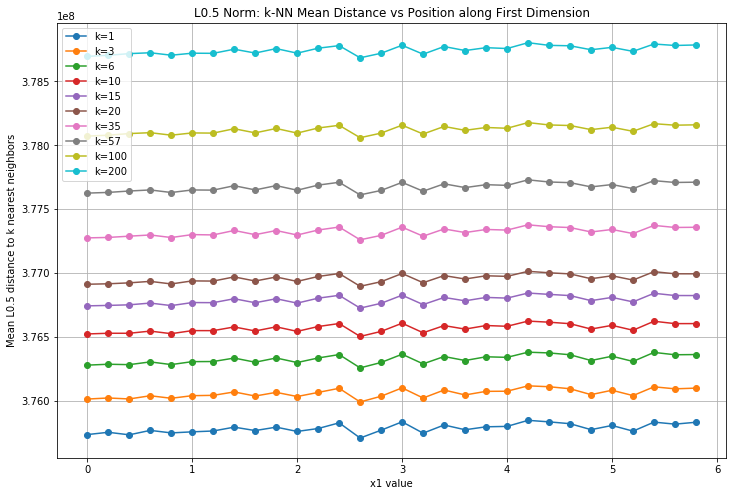

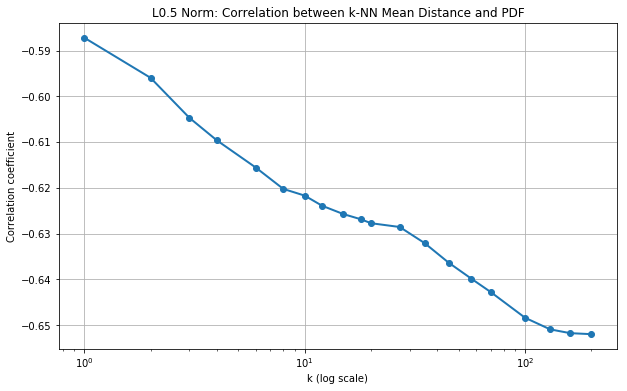

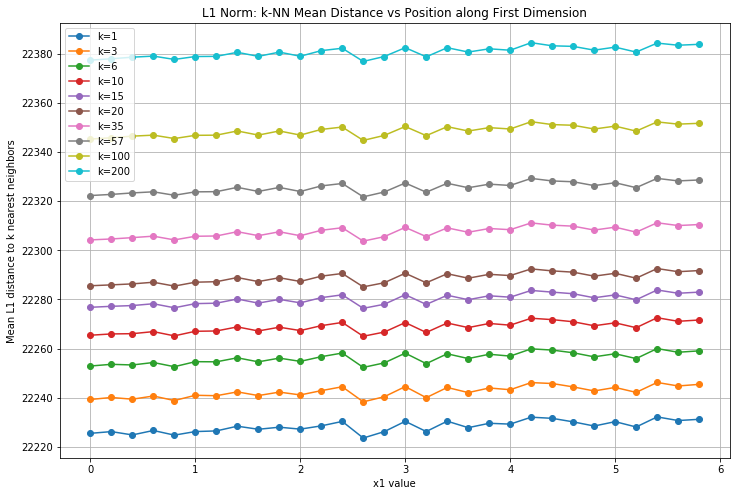

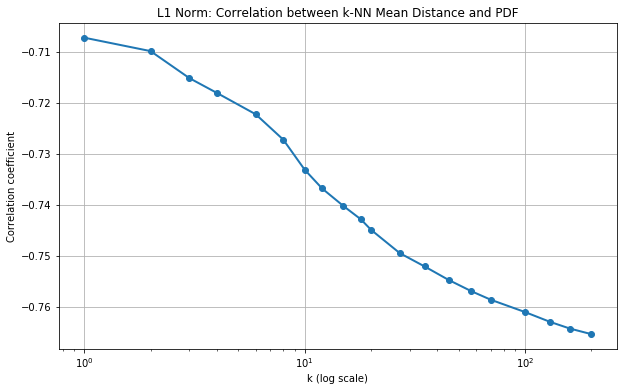

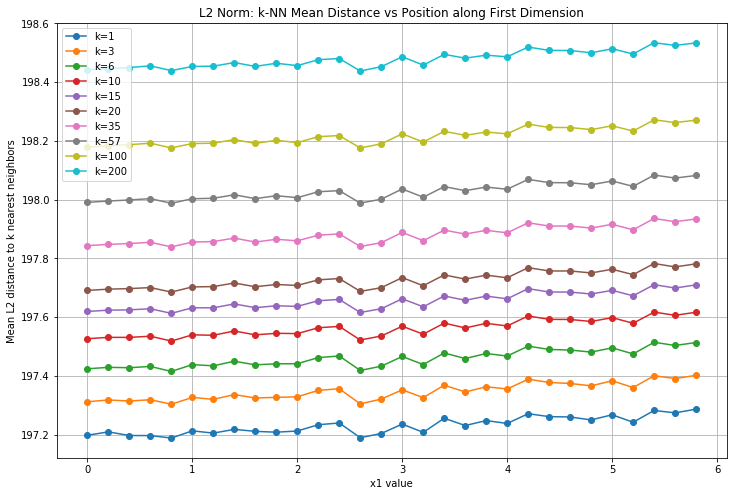

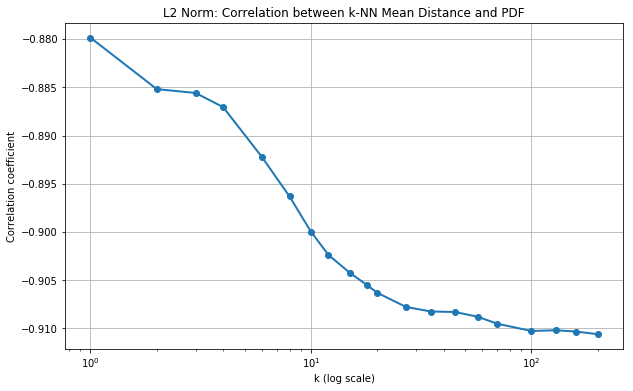

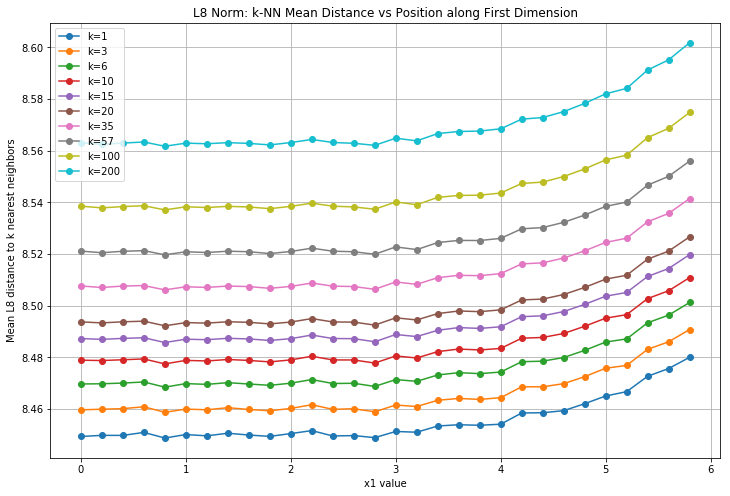

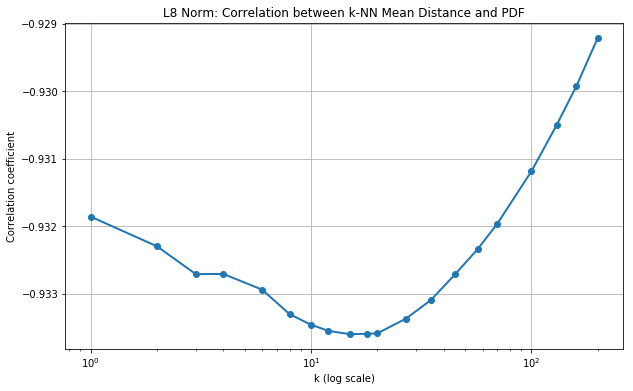

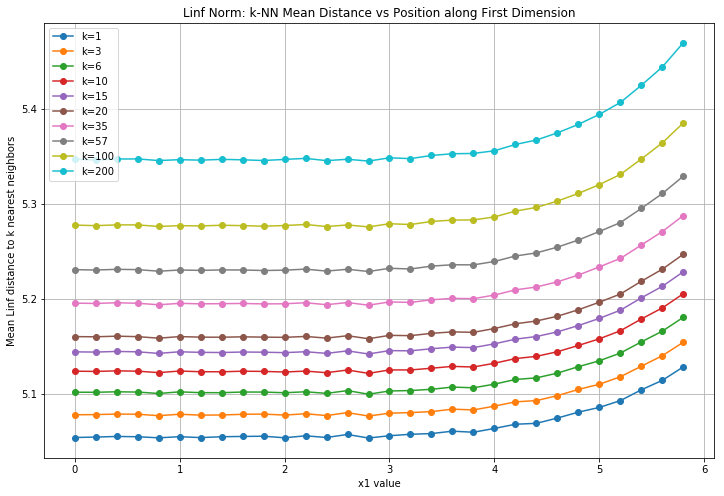

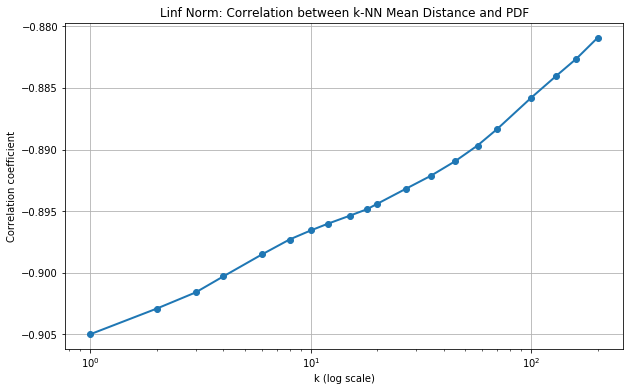

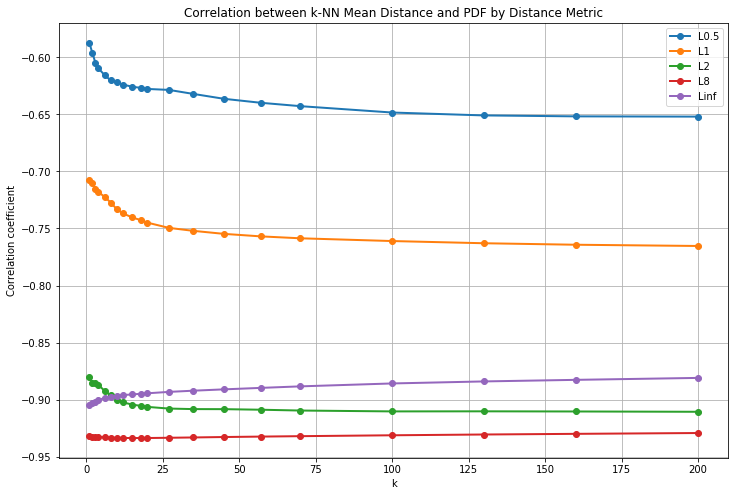

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import time

def knn_analysis(n_points=2000, n_dim=20000, p_norm='2', gpu_id=0, seed=42):
    """
    Analyze k-NN behavior in high dimensions and correlate with PDF using specified p-norm.
    
    Args:
        n_points: Number of points to sample
        n_dim: Dimensionality of the space
        p_norm: Power of the norm to use (1=Manhattan, 2=Euclidean, 'inf'=Chebyshev)
               Can also be values below 1 like 0.5
        gpu_id: GPU to use (0-3)
        seed: Random seed for reproducibility
    """
    # Convert p_norm to appropriate type
    if p_norm == 'inf':
        p = float('inf')
    else:
        p = float(p_norm)
    
    print(f"Running analysis on GPU {gpu_id} with {n_points} points in {n_dim} dimensions")
    print(f"Using L{p_norm} norm (p={p})")
    
    # Set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Set the device
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    if not torch.cuda.is_available():
        print("Warning: CUDA not available, falling back to CPU")
    else:
        print(f"Using device: {device}")
    
    # Generate random points - N(0,I)
    start_time = time.time()
    X = torch.randn(n_points, n_dim, device=device)
    print(f"Generated points in {time.time() - start_time:.2f} seconds")
    
    # Values of k to analyze
    k_values = [1, 2, 3, 4, 6, 8, 10, 12, 15, 18, 20, 27, 35, 45, 57, 70, 100, 130, 160, 200]
    
    # Sample points along first dimension for PDF evaluation
    x1_values = np.arange(0, 6, 0.2)
    n_samples = len(x1_values)
    
    # Store results for each k
    correlations = []
    mean_distances = np.zeros((len(k_values), n_samples))
    
    # Compute log PDF values (without the exponential)
    # n*log(8/sqrt(pi)) + sum xi^2
    log_const = n_dim * np.log(8/np.sqrt(np.pi))
    
    # For each point in x1_values, sample points and compute k-NN distances
    for i, x1 in enumerate(x1_values):
        print(f"Processing x1 = {x1:.1f}")
        
        # Create test points with first dimension fixed to x1
        X_test = torch.randn(n_points, n_dim, device=device)
        X_test[:, 0] = x1  # Set first dimension to x1
        
        # Compute distances based on the norm type
        batch_size = 100
        all_distances = []
        
        for b in range(0, n_points, batch_size):
            end_idx = min(b + batch_size, n_points)
            batch = X_test[b:end_idx]
            
            if p == 2:
                # Special case for Euclidean distance (L2 norm)
                # Use the efficient method
                batch_norm = torch.sum(batch**2, dim=1, keepdim=True)
                X_norm = torch.sum(X**2, dim=1, keepdim=True).T
                dot_product = 2 * torch.mm(batch, X.T)
                dist_sq = batch_norm + X_norm - dot_product
                dist_sq = torch.clamp(dist_sq, min=0.0)  # Handle numerical errors
                distances = torch.sqrt(dist_sq)
            elif p == float('inf'):
                # Special case for maximum norm (L∞)
                # Initialize with zeros (we'll fill with max differences)
                distances = torch.zeros(end_idx - b, n_points, device=device)
                
                # Process in dimension chunks to save memory
                chunk_size = 1000
                for dim_start in range(0, n_dim, chunk_size):
                    dim_end = min(dim_start + chunk_size, n_dim)
                    
                    # Process one dimension at a time to avoid OOM
                    for dim in range(dim_start, dim_end):
                        # Get current dimension values
                        batch_dim = batch[:, dim:dim+1]  # Keep as 2D
                        X_dim = X[:, dim:dim+1].T  # Transpose to match dimensions
                        
                        # Compute absolute differences for this dimension
                        diff = torch.abs(batch_dim - X_dim)
                        
                        # Update max distances if this dimension has larger differences
                        distances = torch.maximum(distances, diff)
            else:
                # General case for any Lp norm
                distances = torch.zeros(end_idx - b, n_points, device=device)
                # Process in dimension chunks to save memory
                chunk_size = 1000
                for dim_start in range(0, n_dim, chunk_size):
                    dim_end = min(dim_start + chunk_size, n_dim)
                    # Get current chunk
                    batch_chunk = batch[:, dim_start:dim_end]
                    X_chunk = X[:, dim_start:dim_end]
                    # Compute powered differences for this chunk
                    diff_chunk = torch.abs(batch_chunk.unsqueeze(1) - X_chunk.unsqueeze(0))
                    powered_diff = torch.pow(diff_chunk, p)
                    # Add to accumulated distances
                    distances += torch.sum(powered_diff, dim=2)
                
                # Apply final power
                distances = torch.pow(distances, 1/p)
            
            all_distances.append(distances)
        
        # Concatenate all batches
        distances_matrix = torch.cat(all_distances, dim=0)
        
        # For each k, compute the mean of the k nearest neighbors
        for j, k in enumerate(k_values):
            # Sort distances and get the k nearest neighbors for each point
            k_nearest, _ = torch.topk(distances_matrix, k+1, dim=1, largest=False)
            
            # Remove the first distance (which might be self-distance)
            k_nearest = k_nearest[:, 1:k+1]
            
            # Compute mean distance to k nearest neighbors
            mean_dist = torch.mean(k_nearest, dim=1).cpu().numpy()
            mean_distances[j, i] = np.mean(mean_dist)
    
    # For each k, compute correlation between mean distance and log PDF
    for j, k in enumerate(k_values):
        # We need to exponentiate log_pdf_term for correlation
        # But to avoid numerical issues, we'll compute correlation with the log values
        # This is valid since correlation is invariant to monotonic transformations
        pdf_values = -0.5 * np.array([log_const + x1**2 for x1 in x1_values])
        corr, p_value = pearsonr(pdf_values, mean_distances[j, :])
        correlations.append((k, corr, p_value))
        print(f"k={k}: correlation={corr:.4f}, p-value={p_value:.4f}")
    
    # Plot results
    plt.figure(figsize=(12, 8))
    
    # If there are many k values, only plot some for clarity
    if len(k_values) > 10:
        plot_indices = np.linspace(0, len(k_values)-1, 10, dtype=int)
        plot_k_values = [k_values[i] for i in plot_indices]
    else:
        plot_indices = range(len(k_values))
        plot_k_values = k_values
    
    for idx in plot_indices:
        plt.plot(x1_values, mean_distances[idx, :], marker='o', label=f'k={k_values[idx]}')
    
    plt.xlabel('x1 value')
    plt.ylabel(f'Mean L{p_norm} distance to k nearest neighbors')
    plt.title(f'L{p_norm} Norm: k-NN Mean Distance vs Position along First Dimension')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'knn_distances_p{p_norm}.png')
    
    # Correlation plot
    plt.figure(figsize=(10, 6))
    k_array = np.array(k_values)
    corr_array = np.array([c[1] for c in correlations])
    
    plt.semilogx(k_array, corr_array, marker='o', linewidth=2)
    plt.xlabel('k (log scale)')
    plt.ylabel('Correlation coefficient')
    plt.title(f'L{p_norm} Norm: Correlation between k-NN Mean Distance and PDF')
    plt.grid(True)
    plt.savefig(f'knn_correlation_p{p_norm}.png')
    
    # Return results
    return {
        'p_norm': p_norm,
        'k_values': k_values,
        'correlations': correlations,
        'mean_distances': mean_distances,
        'x1_values': x1_values
    }

norms_to_test = ['0.5', '1', '2', '8', 'inf']
all_results = {}
for norm in norms_to_test:
    print(f"\nRunning analysis with p-norm = {norm}")
    all_results[norm] = knn_analysis(n_points=2000, n_dim=20000, p_norm=norm, gpu_id=2)
# #
#combined correlation plot for all norms
plt.figure(figsize=(12, 8))
for norm, results in all_results.items():
    k_values = results['k_values']
    correlations = [c[1] for c in results['correlations']]
    plt.plot(k_values, correlations, marker='o', linewidth=2, label=f'L{norm}')
plt.xlabel('k')

plt.ylabel('Correlation coefficient')
plt.title('Correlation between k-NN Mean Distance and PDF by Distance Metric')
plt.legend()
plt.grid(True)
plt.savefig('knn_correlations_all_norms.png')

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, chi2
import time

def knn_analysis(n_points=2000, n_dim=20000, p_norm='2', gpu_id=0, seed=42, n_samples=30):
    """
    Analyze k-NN behavior in high dimensions and correlate with PDF using specified p-norm.
    Samples points according to the distribution rather than regularly spaced points.
    
    Args:
        n_points: Number of points to sample
        n_dim: Dimensionality of the space
        p_norm: Power of the norm to use (1=Manhattan, 2=Euclidean, 'inf'=Chebyshev)
               Can also be values below 1 like 0.5
        gpu_id: GPU to use (0-3)
        seed: Random seed for reproducibility
        n_samples: Number of sample points to evaluate
    """
    # Convert p_norm to appropriate type
    if p_norm == 'inf':
        p = float('inf')
    else:
        p = float(p_norm)
    
    print(f"Running analysis on GPU {gpu_id} with {n_points} points in {n_dim} dimensions")
    print(f"Using L{p_norm} norm (p={p})")
    
    # Set random seed for NumPy
    np.random.seed(seed)
    
    # Set the device
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    if not torch.cuda.is_available():
        print("Warning: CUDA not available, falling back to CPU")
    else:
        print(f"Using device: {device}")
        
    # Set PyTorch seed after device selection (to avoid CUDA graph issues)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
    # Generate random points - N(0,I)
    start_time = time.time()
    X = torch.randn(n_points, n_dim, device=device)
    print(f"Generated reference points in {time.time() - start_time:.2f} seconds")
    
    # Values of k to analyze
    k_values = [1, 2, 3, 4, 6, 8, 10, 12, 15, 18, 20, 27, 35, 45, 57, 70, 100, 130, 160, 200]
    
    # Method 1: Sample points according to chi-squared distribution along first dimension
    # For high-dimensional normal distribution, the squared norm follows chi^2 with df=n_dim
    # We can sample radii from chi^2 and then project onto the first dimension
    
    # Sample according to chi-squared distribution with df=n_dim
    radii_sq = chi2.rvs(df=n_dim, size=n_samples, random_state=seed)
    
    # Sort the samples for better visualization
    radii_sq = np.sort(radii_sq)
    
    # We'll use the square root of these values for the first dimension
    # Since we're working in high dimensions, almost all the mass of a 
    # Gaussian is concentrated on a thin spherical shell
    x1_values = np.sqrt(radii_sq / n_dim)  # Scale by dimensionality
    
    print(f"Sampled {n_samples} points according to chi-squared distribution")
    print(f"x1 range: {min(x1_values):.2f} to {max(x1_values):.2f}")
    
    # Store results for each k
    correlations = []
    mean_distances = np.zeros((len(k_values), n_samples))
    
    # Compute log PDF values (without the exponential)
    # n*log(8/sqrt(pi)) + sum xi^2
    log_const = n_dim * np.log(8/np.sqrt(np.pi))
    
    # For each sampled point, compute k-NN distances
    for i, x1 in enumerate(x1_values):
        print(f"Processing x1 = {x1:.3f} (sample {i+1}/{n_samples})")
        
        # Create test points with first dimension fixed to x1
        X_test = torch.randn(n_points, n_dim, device=device)
        
        # Set first dimension to x1 and normalize the rest to maintain distribution
        # We need to adjust other dimensions to ensure the point follows N(0,I)
        # in all dimensions but with the constraint on the first dimension
        
        # First ensure other dimensions follow N(0,1)
        for d in range(1, n_dim):
            X_test[:, d] = torch.randn(n_points, device=device)
        
        # Set first dimension to x1
        X_test[:, 0] = x1
        
        # Compute distances based on the norm type
        batch_size = 100
        all_distances = []
        
        for b in range(0, n_points, batch_size):
            end_idx = min(b + batch_size, n_points)
            batch = X_test[b:end_idx]
            
            if p == 2:
                # Special case for Euclidean distance (L2 norm)
                # Use the efficient method
                batch_norm = torch.sum(batch**2, dim=1, keepdim=True)
                X_norm = torch.sum(X**2, dim=1, keepdim=True).T
                dot_product = 2 * torch.mm(batch, X.T)
                dist_sq = batch_norm + X_norm - dot_product
                dist_sq = torch.clamp(dist_sq, min=0.0)  # Handle numerical errors
                distances = torch.sqrt(dist_sq)
            elif p == float('inf'):
                # Special case for maximum norm (L∞)
                # Initialize with zeros (we'll fill with max differences)
                distances = torch.zeros(end_idx - b, n_points, device=device)
                
                # Process one dimension at a time to avoid OOM
                for dim in range(n_dim):
                    # Get current dimension values
                    batch_dim = batch[:, dim:dim+1]  # Keep as 2D
                    X_dim = X[:, dim:dim+1].T  # Transpose to match dimensions
                    
                    # Compute absolute differences for this dimension
                    diff = torch.abs(batch_dim - X_dim)
                    
                    # Update max distances if this dimension has larger differences
                    distances = torch.maximum(distances, diff)
            else:
                # General case for any Lp norm
                distances = torch.zeros(end_idx - b, n_points, device=device)
                # Process in dimension chunks to save memory
                chunk_size = 1000
                for dim_start in range(0, n_dim, chunk_size):
                    dim_end = min(dim_start + chunk_size, n_dim)
                    # Get current chunk
                    batch_chunk = batch[:, dim_start:dim_end]
                    X_chunk = X[:, dim_start:dim_end]
                    # Compute powered differences for this chunk
                    diff_chunk = torch.abs(batch_chunk.unsqueeze(1) - X_chunk.unsqueeze(0))
                    powered_diff = torch.pow(diff_chunk, p)
                    # Add to accumulated distances
                    distances += torch.sum(powered_diff, dim=2)
                
                # Apply final power
                distances = torch.pow(distances, 1/p)
            
            all_distances.append(distances)
        
        # Concatenate all batches
        distances_matrix = torch.cat(all_distances, dim=0)
        
        # For each k, compute the mean of the k nearest neighbors
        for j, k in enumerate(k_values):
            # Sort distances and get the k nearest neighbors for each point
            k_nearest, _ = torch.topk(distances_matrix, k+1, dim=1, largest=False)
            
            # Remove the first distance (which might be self-distance)
            k_nearest = k_nearest[:, 1:k+1]
            
            # Compute mean distance to k nearest neighbors
            mean_dist = torch.mean(k_nearest, dim=1).cpu().numpy()
            mean_distances[j, i] = np.mean(mean_dist)
    
    # Calculate PDF values for the sampled points
    pdf_values = -0.5 * np.array([log_const + x1**2 for x1 in x1_values])
    
    # For each k, compute correlation between mean distance and log PDF
    for j, k in enumerate(k_values):
        corr, p_value = pearsonr(pdf_values, mean_distances[j, :])
        correlations.append((k, corr, p_value))
        print(f"k={k}: correlation={corr:.4f}, p-value={p_value:.4f}")
    
    # Plot results
    plt.figure(figsize=(12, 8))
    
    # If there are many k values, only plot some for clarity
    if len(k_values) > 10:
        plot_indices = np.linspace(0, len(k_values)-1, 10, dtype=int)
        plot_k_values = [k_values[i] for i in plot_indices]
    else:
        plot_indices = range(len(k_values))
        plot_k_values = k_values
    
    for idx in plot_indices:
        plt.plot(x1_values, mean_distances[idx, :], marker='o', label=f'k={k_values[idx]}')
    
    plt.xlabel('x1 value (sampled according to distribution)')
    plt.ylabel(f'Mean L{p_norm} distance to k nearest neighbors')
    plt.title(f'L{p_norm} Norm: k-NN Mean Distance vs Position (Distribution-Sampled)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'knn_distances_p{p_norm}_chi2_sampled.png')
    
    # Correlation plot
    plt.figure(figsize=(10, 6))
    k_array = np.array(k_values)
    corr_array = np.array([c[1] for c in correlations])
    
    plt.semilogx(k_array, corr_array, marker='o', linewidth=2)
    plt.xlabel('k (log scale)')
    plt.ylabel('Correlation coefficient')
    plt.title(f'L{p_norm} Norm: Correlation between k-NN Mean Distance and PDF')
    plt.grid(True)
    plt.savefig(f'knn_correlation_p{p_norm}_chi2_sampled.png')
    
    # Alternative: Plot mean distances against PDF values
    plt.figure(figsize=(12, 8))
    
    # Normalize PDF values to compare shapes
    norm_pdf = (pdf_values - np.min(pdf_values)) / (np.max(pdf_values) - np.min(pdf_values))
    
    for idx in plot_indices:
        # Normalize distances for visualization
        norm_dist = (mean_distances[idx, :] - np.min(mean_distances[idx, :])) / \
                     (np.max(mean_distances[idx, :]) - np.min(mean_distances[idx, :]))
        plt.plot(x1_values, norm_dist, marker='o', label=f'k={k_values[idx]}')
    
    # Add normalized PDF
    plt.plot(x1_values, norm_pdf, 'k--', linewidth=2, label='Normalized PDF')
    
    plt.xlabel('x1 value (sampled according to distribution)')
    plt.ylabel('Normalized values')
    plt.title(f'L{p_norm} Norm: Comparison of k-NN Mean Distance and PDF')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'knn_distances_vs_pdf_p{p_norm}_chi2_sampled.png')
    
    # Return results
    return {
        'p_norm': p_norm,
        'k_values': k_values,
        'correlations': correlations,
        'mean_distances': mean_distances,
        'x1_values': x1_values,
        'pdf_values': pdf_values
    }


# Example usage
norms_to_test = ['3', '1', '2', '4','5','6','7']
all_results = {}
for norm in norms_to_test:
    print(f"\nRunning analysis with p-norm = {norm}")
    all_results[norm] = knn_analysis(n_points=2000, n_dim=20000, p_norm=norm, gpu_id=1, n_samples=200)

# Combined correlation plot for all norms
plt.figure(figsize=(12, 8))
for norm, results in all_results.items():
    k_values = results['k_values']
    correlations = [c[1] for c in results['correlations']]
    plt.plot(k_values, correlations, marker='o', linewidth=2, label=f'L{norm}')
plt.xlabel('k')
plt.ylabel('Correlation coefficient')
plt.title('Correlation between k-NN Mean Distance and PDF by Distance Metric')
plt.legend()
plt.grid(True)
plt.savefig('knn_correlations_all_norms_chi2_sampled.png')


Running analysis with p-norm = 3
Running analysis on GPU 1 with 2000 points in 20000 dimensions
Using L3 norm (p=3.0)
Using device: cuda:1
Generated reference points in 3.72 seconds
Sampled 200 points according to chi-squared distribution
x1 range: 0.98 to 1.02
Processing x1 = 0.984 (sample 1/200)
Processing x1 = 0.990 (sample 2/200)
Processing x1 = 0.990 (sample 3/200)
Processing x1 = 0.990 (sample 4/200)
Processing x1 = 0.991 (sample 5/200)
Processing x1 = 0.992 (sample 6/200)
Processing x1 = 0.992 (sample 7/200)
Processing x1 = 0.992 (sample 8/200)
Processing x1 = 0.993 (sample 9/200)
Processing x1 = 0.993 (sample 10/200)
Processing x1 = 0.993 (sample 11/200)
Processing x1 = 0.993 (sample 12/200)
Processing x1 = 0.993 (sample 13/200)
Processing x1 = 0.994 (sample 14/200)
Processing x1 = 0.994 (sample 15/200)
Processing x1 = 0.994 (sample 16/200)
Processing x1 = 0.994 (sample 17/200)
Processing x1 = 0.994 (sample 18/200)
Processing x1 = 0.994 (sample 19/200)
Processing x1 = 0.995 (s

In [ ]:
from numba import cuda
cuda.select_device(2)
cuda.close()